# Patient Stroke Prediction


Alfred Hofmann

In [1]:
# Imports here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split, KFold

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.preprocessing import StandardScaler

import warnings
from sklearn.exceptions import ConvergenceWarning

import statsmodels.formula.api as smf

from sklearn.cluster import KMeans

# Ignore scikit-learn ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Introduction

Our main research goal is to build a predictive model that will effectively predict the probability a patient will have a stroke. While trying to find a predictive model for new datasets, we also as a secondary research goal want to see what variable in our dataset has the most predictive power when it comes to predicting if a person has a stroke or not. The variables we have in our dataset are all related to one observation which is related to a person. The variables are if they have had a stroke, heart disease, hypertension, their age, average glucose level, bmi, and smoking status. The response variable is if they have had a stroke or not and the rest are the explanatory variables. Another research goal is that we want to describe the nature of the explanatory variables as well as the relationship between the variables that we are using in our model, interpreted in the context of our primary research goal.
A person who might find this information useful is a doctor. A doctor could use these results to find out what makes a person have a stroke and what are ways they can prevent having a stroke. Also this information would be good for the general public so everyone knows if they are likely to have a stroke or not and try to prevent it from happening. For the classifiers, the doctors and clinical units would want a higher success rate for the if a person has a stroke (positive) than not having a stroke (negative). We'd rather for a person to falsely be classified as likely for a stroke than a person who does not seem to be likely for a stroke and then has one. So, in this data, we will be more focused on the true positivity rate than the opposite.



### Citations
https://www.cdc.gov/stroke/prevention.htm#:~:text=Choose%20healthy%20foods%20and%20drinks&text=Eating%20foods%20low%20in%20saturated,chances%20of%20having%20a%20stroke.

https://aphasia.org/aphasia-resources/stroke/?gad_source=1&gclid=CjwKCAjwxLKxBhA7EiwAXO0R0Mdbl5U1dWRWx5j5dBAO1VdhbVHOseSaT9rBxoGibNmd8KDbDdWj4BoCnCkQAvD_BwE


## 2. Dataset Discussion

### Dataset Display

Let's take a look at the first five rows of our original dataset.

In [2]:
df = pd.read_csv('stroke_data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
rows = df.shape[0]
print(f'Initial number of rows in the dataset: {rows}')

Initial number of rows in the dataset: 5110


### Dataset Source

Link to dataset: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

### Selected Variables

The explanatory variables we are using in this analysis are age, hypertension, heart disease, average glucose level, bmi, and smoking status. The response variable of course is stroke.

In [4]:
selected_variables = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
df = df[selected_variables]
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,67.0,0,1,228.69,36.6,formerly smoked,1
1,61.0,0,0,202.21,NaN,never smoked,1
2,80.0,0,1,105.92,32.5,never smoked,1
3,49.0,0,0,171.23,34.4,smokes,1
4,79.0,1,0,174.12,24.0,never smoked,1


## 3. Dataset Cleaning

### Missing Value Detection and Cleaning

We begin this data cleaning by seeing if there are any explicit missing values in our filtered dataset.

In [5]:
# Explicit missing values check
df.isna().sum()

age                    0
hypertension           0
heart_disease          0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Now, we check for implicit missing values by seeing if all numeric variables contain only all float or int types.

In [6]:
# Implicit missing values
df.dtypes

age                  float64
hypertension           int64
heart_disease          int64
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Everything matches up well, but we will inspect the smoking_status values to see if there are implicit missing values.

In [7]:
# Implicit missing values
np.unique(df['smoking_status'].values)

array(['Unknown', 'formerly smoked', 'never smoked', 'smokes'],
      dtype=object)

Implicit missing values in smoking_status are indicated by 'Unknown', so let's drop these.

In [8]:
df = pd.read_csv('stroke_data.csv', na_values=['Unknown'])
df = df[selected_variables]
df.isna().sum()

age                     0
hypertension            0
heart_disease           0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64

Now we can simply drop all the rows with NaN values.

In [9]:
df = df.dropna()
new_num_rows = df.shape[0]
rows_dropped = rows - new_num_rows
print(f'Number of rows dropped: {rows_dropped}')

# Reset rows variable
rows = new_num_rows

Number of rows dropped: 1684


### Sample Size Cleaning

First, I want to change my variables 'hypertension' and 'heart_disease' to more clearly represent categorical variables, since they are both just binary categorical variables currently represented in numeric binary form. I will convert them to more descriptive string values just for clarity.

In [10]:
df['hypertension'] = df['hypertension'].map({0: "no hypertension", 1: "has hypertension"})
df['heart_disease'] = df['heart_disease'].map({0: "no heart disease", 1: "has heart disease"})
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,67.0,no hypertension,has heart disease,228.69,36.6,formerly smoked,1
2,80.0,no hypertension,has heart disease,105.92,32.5,never smoked,1
3,49.0,no hypertension,no heart disease,171.23,34.4,smokes,1
4,79.0,has hypertension,no heart disease,174.12,24.0,never smoked,1
5,81.0,no hypertension,no heart disease,186.21,29.0,formerly smoked,1


I also want to do the same with my response variable (for now), but I will later change this back to a 0/1 indicator variable for logistic regression. I am only changing now for clarity.

In [11]:
df['stroke'] = df['stroke'].map({0: "no stroke", 1: "stroke occurred"})
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,67.0,no hypertension,has heart disease,228.69,36.6,formerly smoked,stroke occurred
2,80.0,no hypertension,has heart disease,105.92,32.5,never smoked,stroke occurred
3,49.0,no hypertension,no heart disease,171.23,34.4,smokes,stroke occurred
4,79.0,has hypertension,no heart disease,174.12,24.0,never smoked,stroke occurred
5,81.0,no hypertension,no heart disease,186.21,29.0,formerly smoked,stroke occurred


Now, we are checking if any of the categories in categorical variables have a very low number of examples.

In [12]:
df['hypertension'].value_counts()

hypertension
no hypertension     3018
has hypertension     408
Name: count, dtype: int64

In [13]:
df['heart_disease'].value_counts()

heart_disease
no heart disease     3220
has heart disease     206
Name: count, dtype: int64

In [14]:
df['smoking_status'].value_counts()

smoking_status
never smoked       1852
formerly smoked     837
smokes              737
Name: count, dtype: int64

All categories have ample amounts of data.

### Outlier Cleaning - Two Variable Outlier Inspection

Next, we will check if there are any outliers when plotting two explanatory variables against each other.

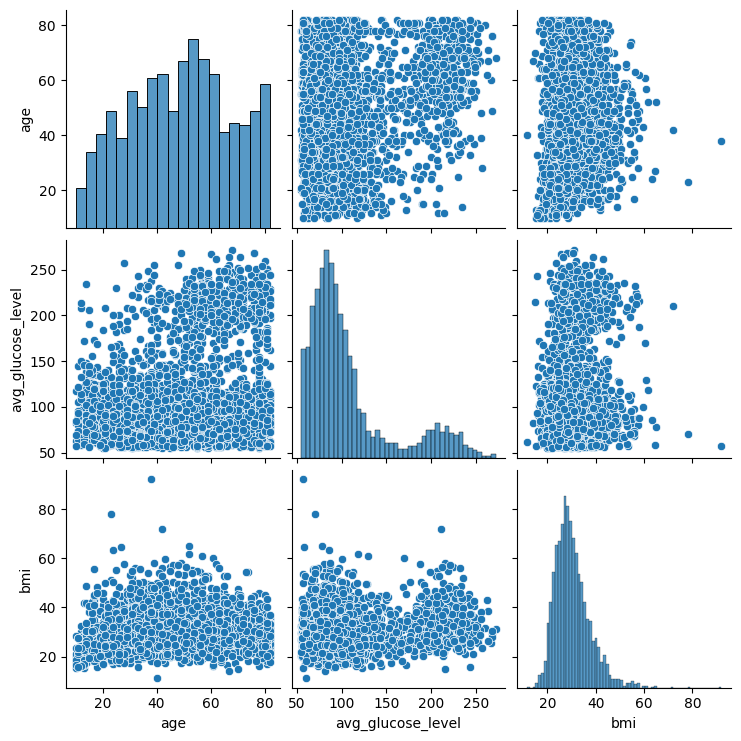

In [15]:
sns.pairplot(df.drop('stroke', axis=1))
plt.show()

There doesn't appear to be any major outliers, we will keep the relatively small outliers in to be better able to predict similar values.

### Other Data Cleaning

Now, we will plot each numeric explanatory variables by themselves to see if there are outliers in the respect.

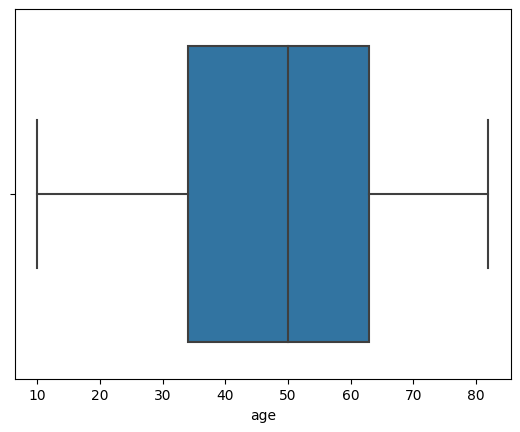

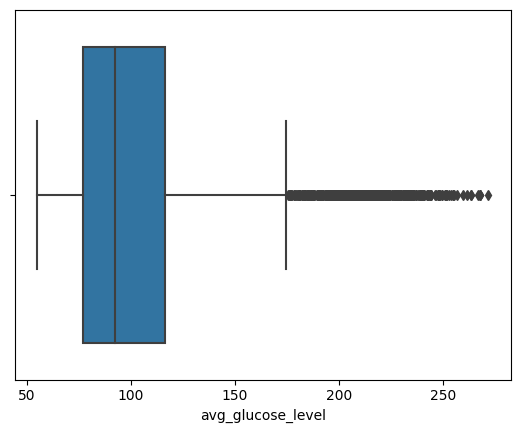

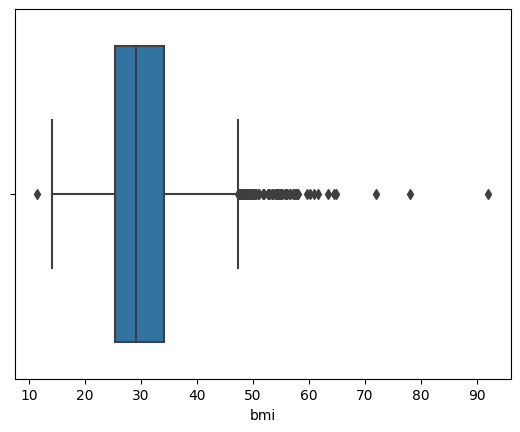

In [16]:
# Checking single variable outliers
sns.boxplot(x=df['age'])
plt.show()
sns.boxplot(x=df['avg_glucose_level'])
plt.show()
sns.boxplot(x=df['bmi'])
plt.show()

We now want to see precisely the number of outliers there are in average glucose level and bmi, because there seem to be many for each, and we want to be careful not to lose too much data.

In [17]:
# Calculating avg glucose level outliers
Q1 = df['avg_glucose_level'].quantile(0.25)
Q3 = df['avg_glucose_level'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['avg_glucose_level'] < lower_bound) | (df['avg_glucose_level'] > upper_bound)]
n_glucose_outliers = outliers.shape[0]
print(f'Number of avg glucose level outliers: {n_glucose_outliers}')

Number of avg glucose level outliers: 465


In [18]:
# Calculating BMI outliers
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['bmi'] < lower_bound) | (df['bmi'] > upper_bound)]
n_bmi_outliers = outliers.shape[0]
print(f'Number of BMI outliers: {n_bmi_outliers}')

Number of BMI outliers: 90


We will get drop the rows with the relatively big outliers only, because we don't want to lose too much data. This will make our model be able to better predict non-outlier points better (but still be able to predict smaller outliers well).

In [19]:
# Getting rid of only the "big" outliers
df = df[df['bmi'] < 70]
new_num_rows = df.shape[0]
rows_dropped = rows - new_num_rows
print(f'Number of rows dropped: {rows_dropped}')

# Reset rows variable
rows = new_num_rows

Number of rows dropped: 3


### Cleaning Discussion
For our dataset cleaning, we had one column with implicit missing values. This column was the smoking status column, and it has values named unknown. I decided to convert the unknown values to NaN values and drop all NaN values in the dataset. The pros of doing this is we will have more accurate results when it comes to figuring out the predictive power of smoking status to having a stroke. A con is we are getting rid of observations, so our results will not give us the “full story” of the dataset. When it came to outliers, we decided to only drop the big outliers in the dataset. We felt this was the best idea so we could still keep most of the observations in the dataset. We ended up only dropping 1687 rows after dropping all the NaN values and outlier rows. We believe we will get the best results with taking these steps in our dataset.

## 4. Preliminary Analysis

### Relationships between the Response Variable and the Explanatory Variables

Let's plot each explanatory variable to the response variable to be able to better visualize this data.

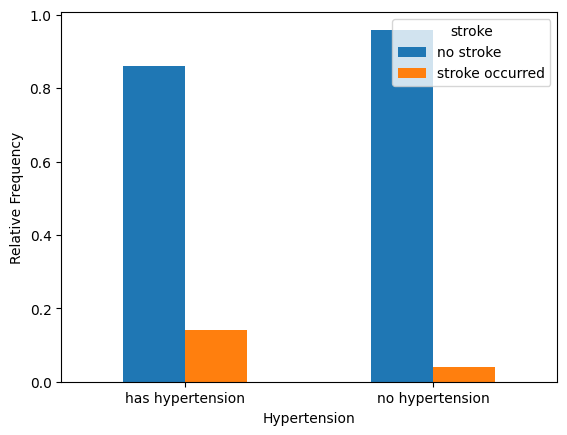

In [20]:
temp = pd.crosstab(df['hypertension'], df['stroke'], normalize='index')
temp.plot.bar()
plt.ylabel('Relative Frequency')
plt.xticks(rotation=0)
plt.xlabel('Hypertension')
plt.show()

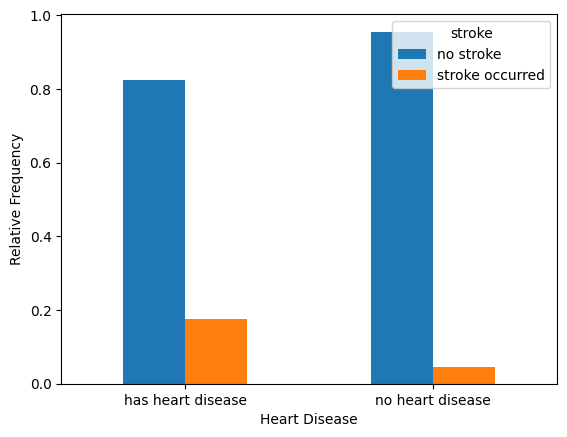

In [21]:
temp = pd.crosstab(df['heart_disease'], df['stroke'], normalize='index')
temp.plot.bar()
plt.ylabel('Relative Frequency')
plt.xticks(rotation=0)
plt.xlabel('Heart Disease')
plt.show()

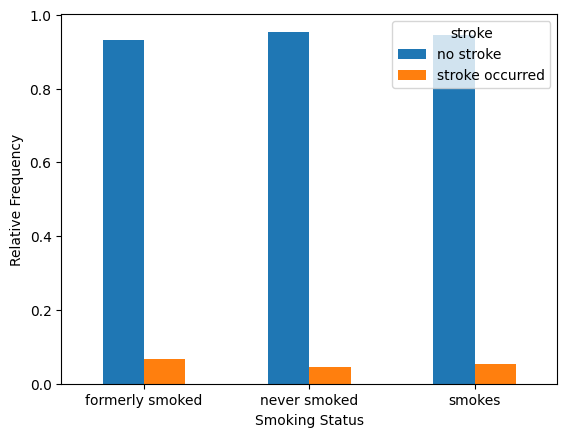

In [22]:
temp = pd.crosstab(df['smoking_status'], df['stroke'], normalize='index')
temp.plot.bar()
plt.ylabel('Relative Frequency')
plt.xticks(rotation=0)
plt.xlabel('Smoking Status')
plt.show()

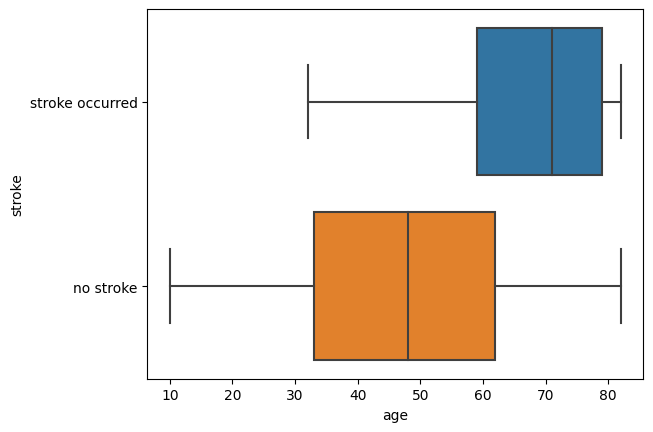

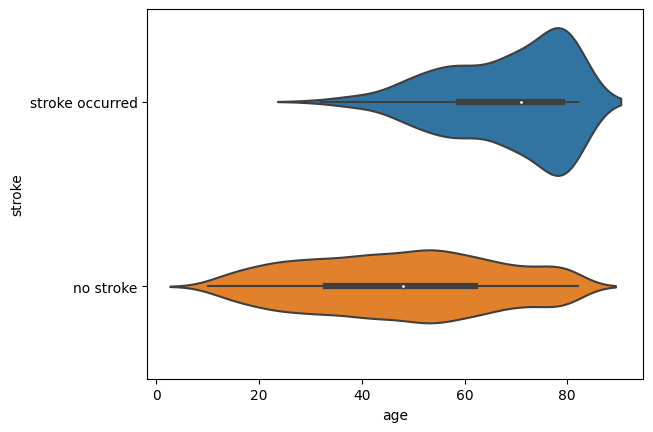

In [23]:
sns.boxplot(x='age', y='stroke', data=df)
plt.show()
sns.violinplot(x='age', y='stroke', data=df)
plt.show()

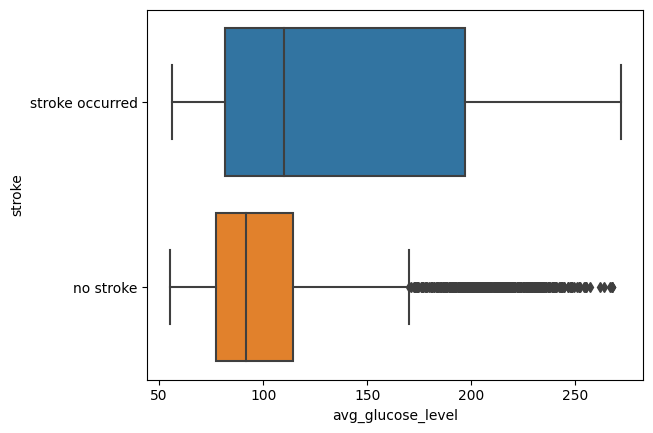

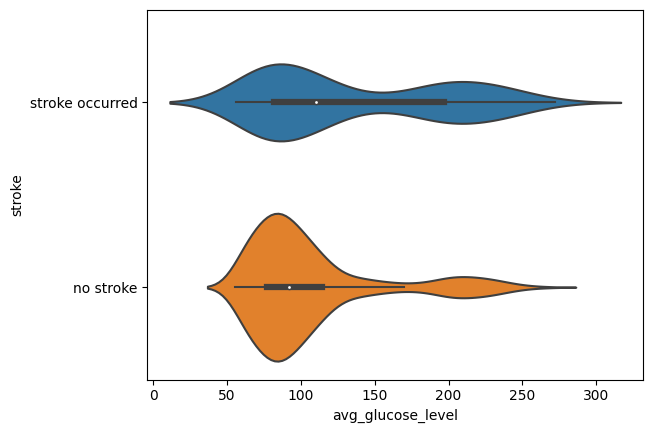

In [24]:
sns.boxplot(x='avg_glucose_level', y='stroke', data=df)
plt.show()
sns.violinplot(x='avg_glucose_level', y='stroke', data=df)
plt.show()

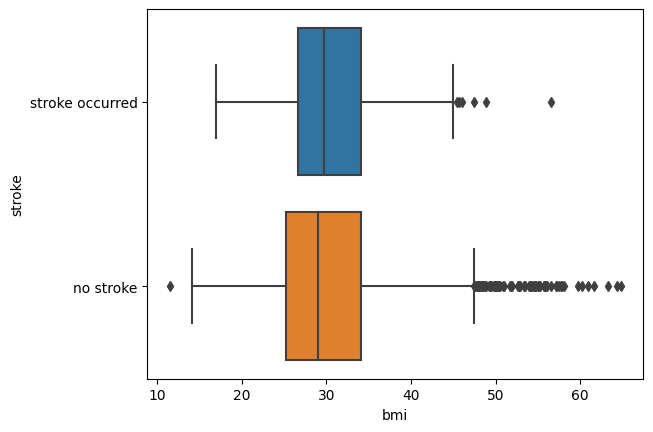

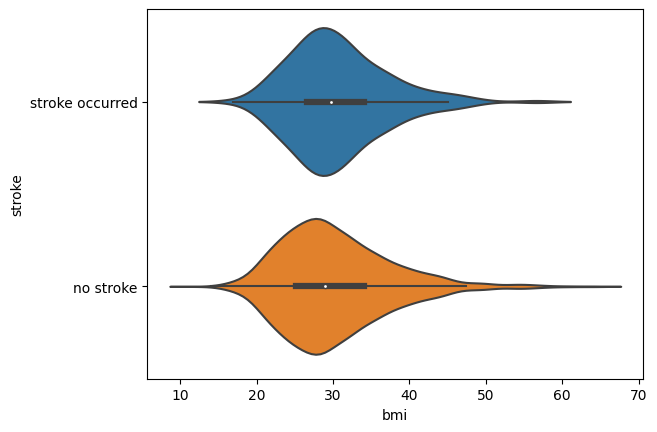

In [25]:
sns.boxplot(x='bmi', y='stroke', data=df)
plt.show()
sns.violinplot(x='bmi', y='stroke', data=df)
plt.show()

### Relationships between Explanatory Variable Pairs

Now, we will examine the relationship between all explanatory variable pairs so we can better visualize their associations.

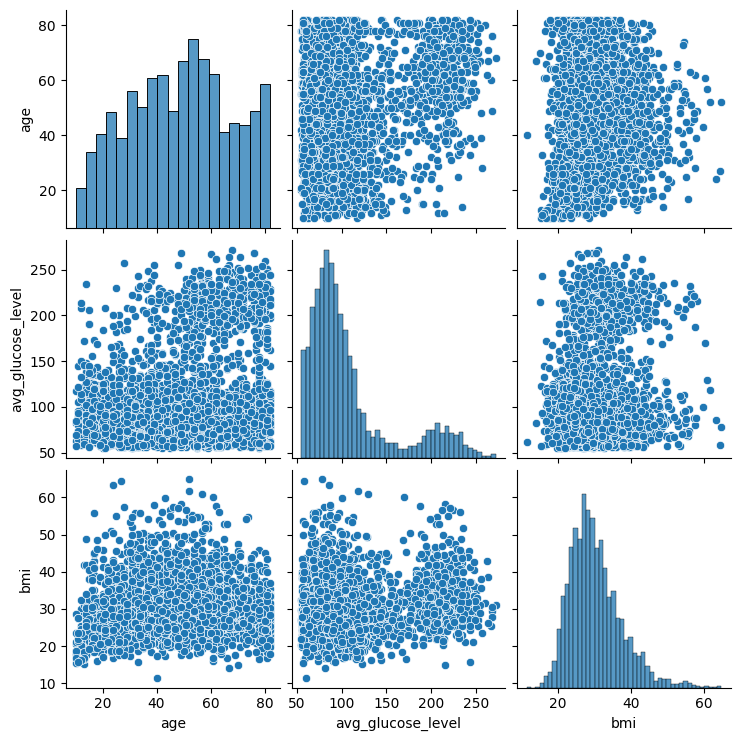

In [26]:
# All numeric explanatory pairs
sns.pairplot(df.drop('stroke', axis=1))
plt.show()

#### Age with all categorical pairs

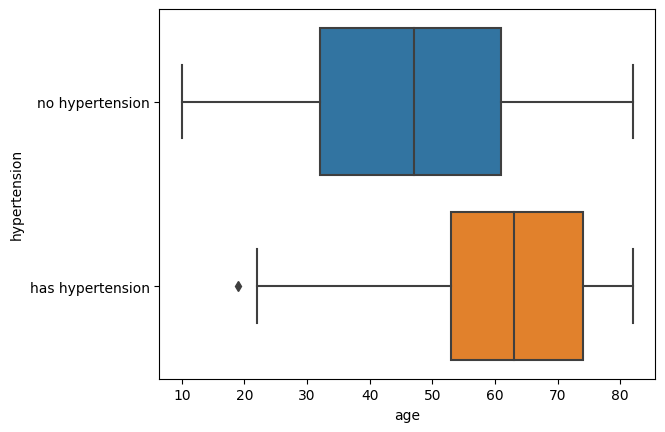

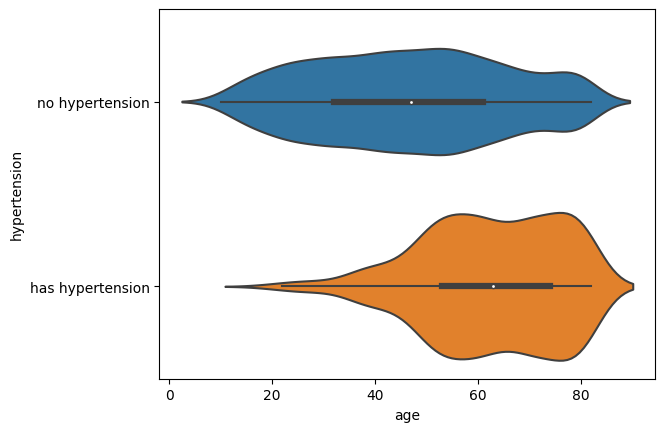

In [27]:
sns.boxplot(x='age', y='hypertension', data=df)
plt.show()
sns.violinplot(x='age', y='hypertension', data=df)
plt.show()

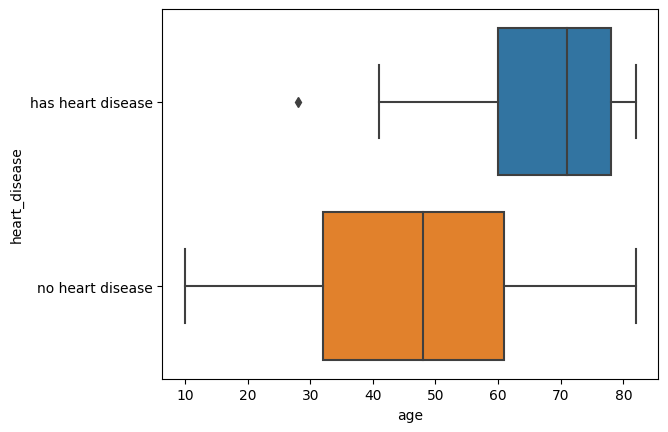

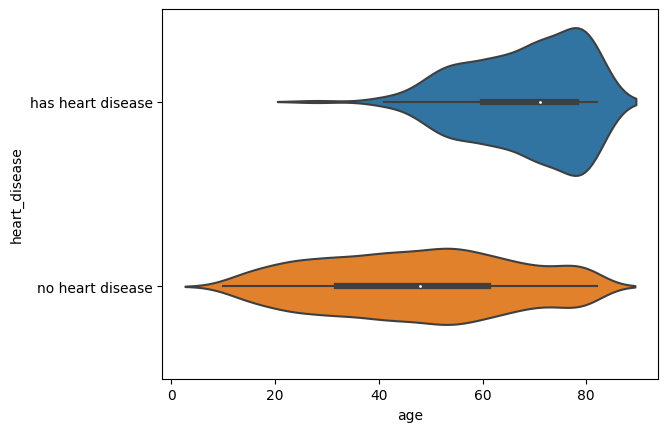

In [28]:
sns.boxplot(x='age', y='heart_disease', data=df)
plt.show()
sns.violinplot(x='age', y='heart_disease', data=df)
plt.show()

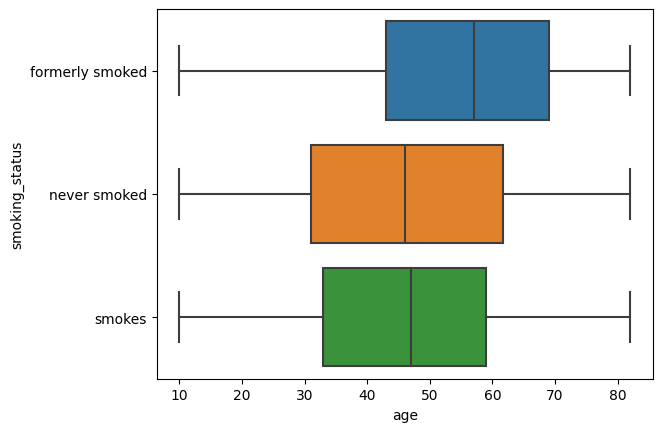

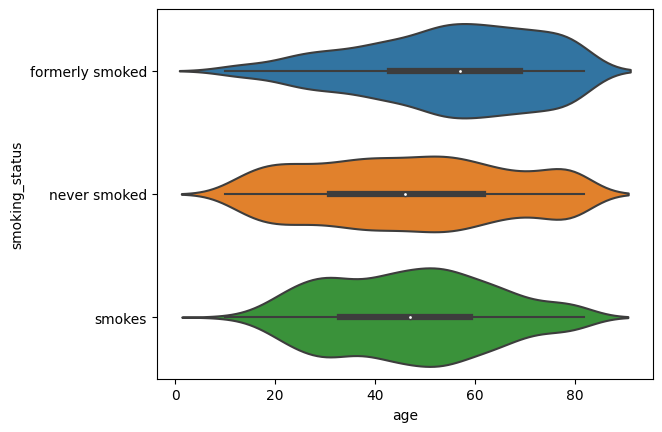

In [29]:
sns.boxplot(x='age', y='smoking_status', data=df)
plt.show()
sns.violinplot(x='age', y='smoking_status', data=df)
plt.show()

#### Avg Glucose Levels with all categorical pairs

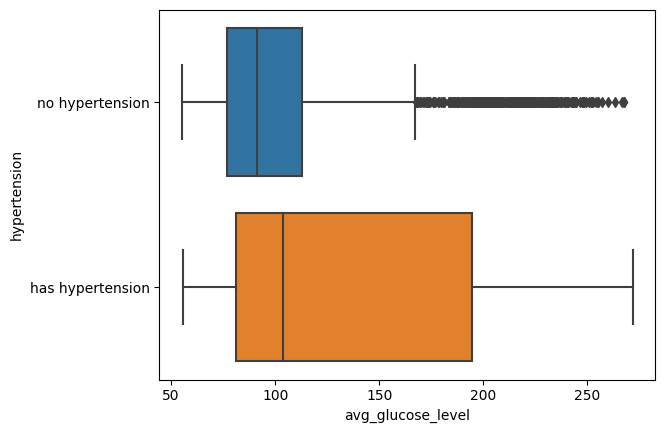

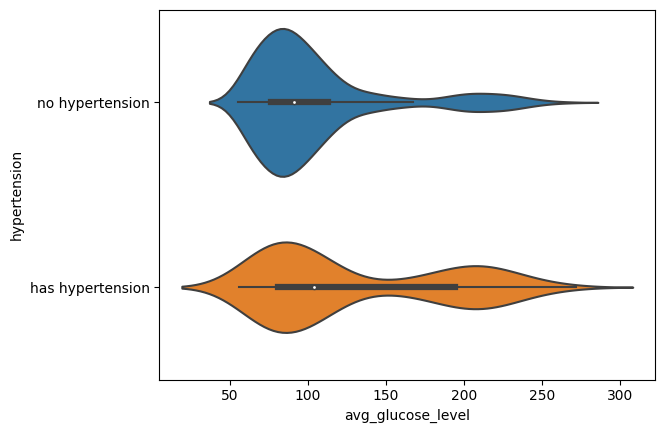

In [30]:
sns.boxplot(x='avg_glucose_level', y='hypertension', data=df)
plt.show()
sns.violinplot(x='avg_glucose_level', y='hypertension', data=df)
plt.show()

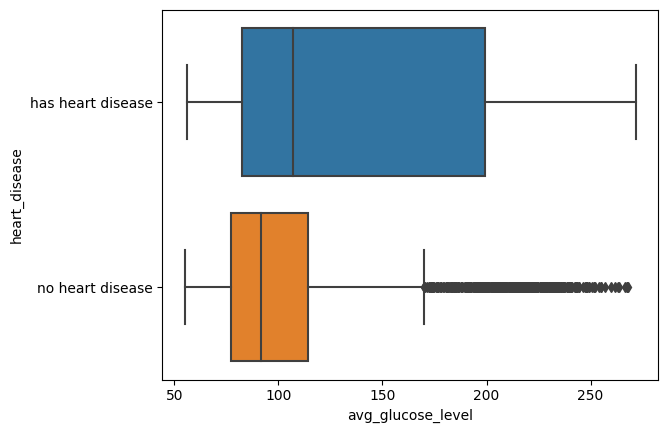

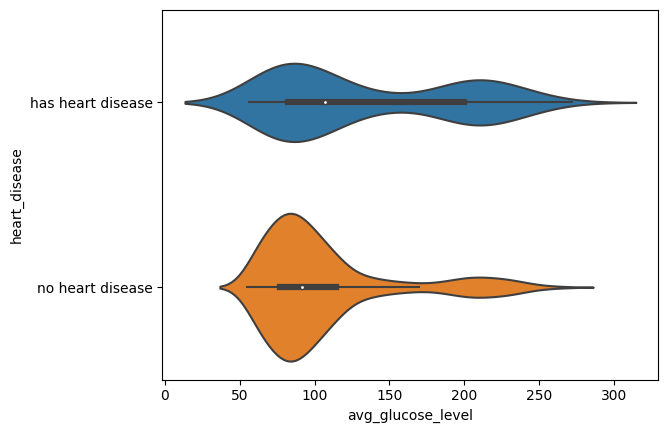

In [31]:
sns.boxplot(x='avg_glucose_level', y='heart_disease', data=df)
plt.show()
sns.violinplot(x='avg_glucose_level', y='heart_disease', data=df)
plt.show()

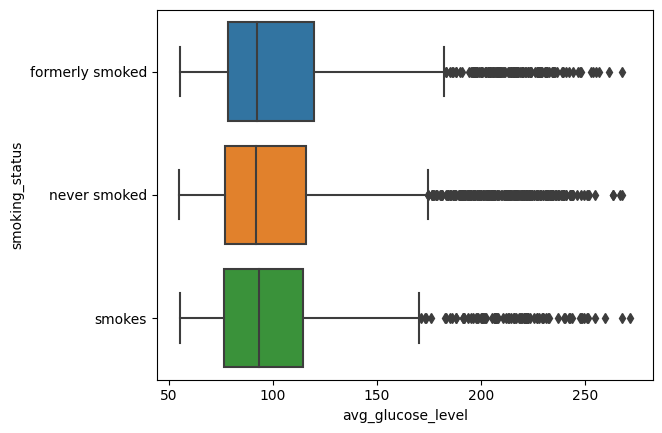

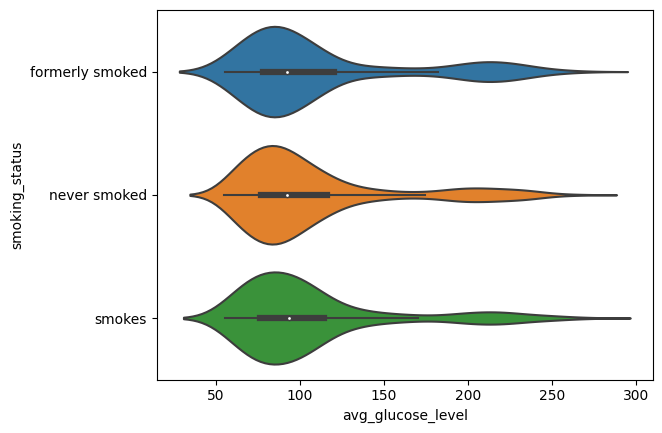

In [32]:
sns.boxplot(x='avg_glucose_level', y='smoking_status', data=df)
plt.show()
sns.violinplot(x='avg_glucose_level', y='smoking_status', data=df)
plt.show()

#### BMI with all categorical pairs

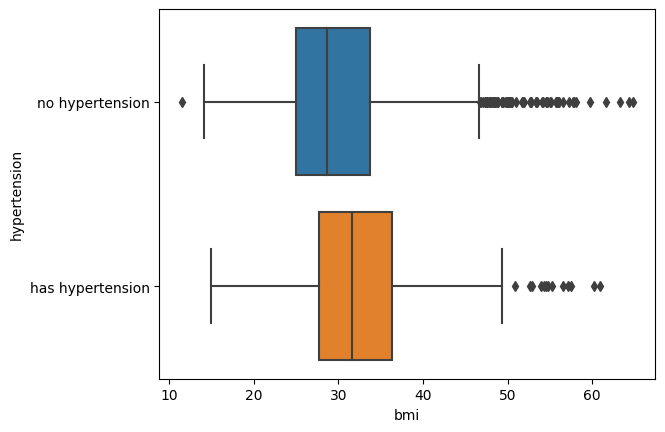

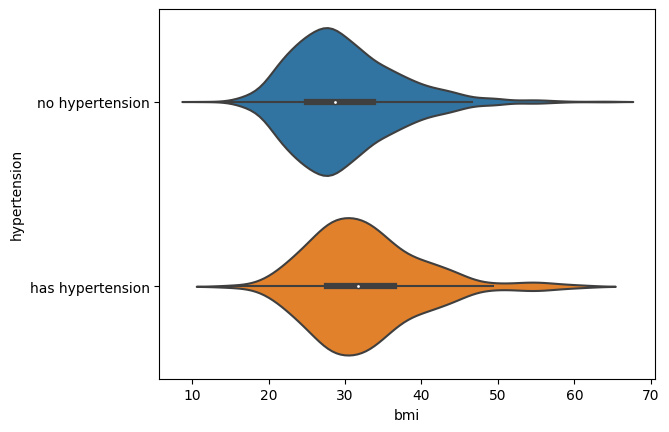

In [33]:
sns.boxplot(x='bmi', y='hypertension', data=df)
plt.show()
sns.violinplot(x='bmi', y='hypertension', data=df)
plt.show()

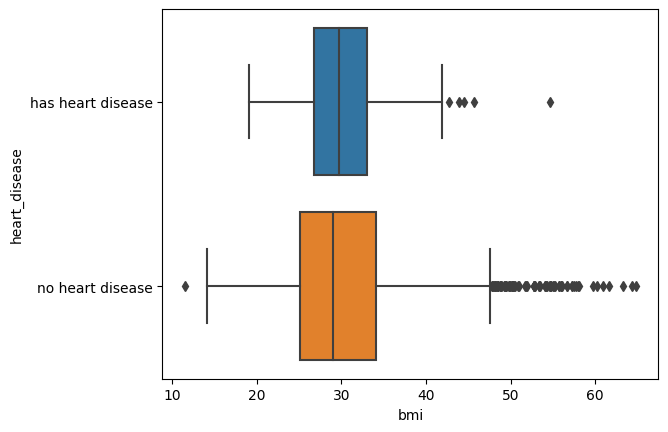

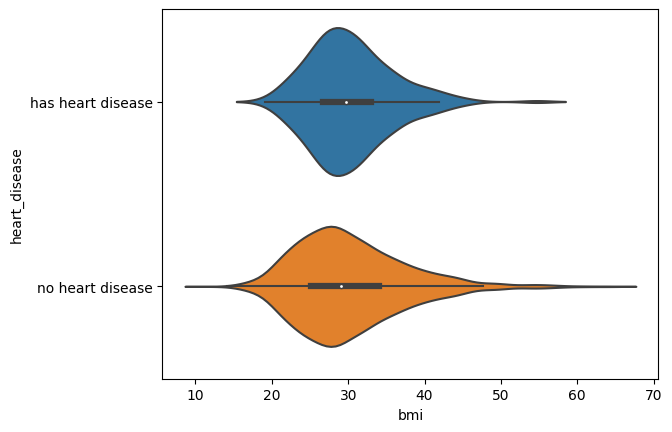

In [34]:
sns.boxplot(x='bmi', y='heart_disease', data=df)
plt.show()
sns.violinplot(x='bmi', y='heart_disease', data=df)
plt.show()

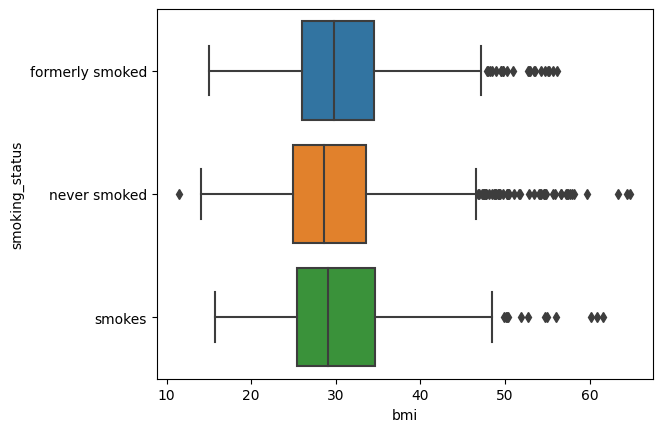

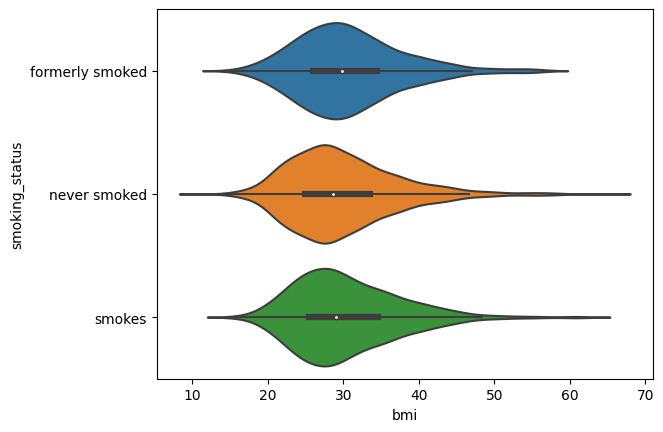

In [35]:
sns.boxplot(x='bmi', y='smoking_status', data=df)
plt.show()
sns.violinplot(x='bmi', y='smoking_status', data=df)
plt.show()

#### Categorical Explanatory Variable Pairs


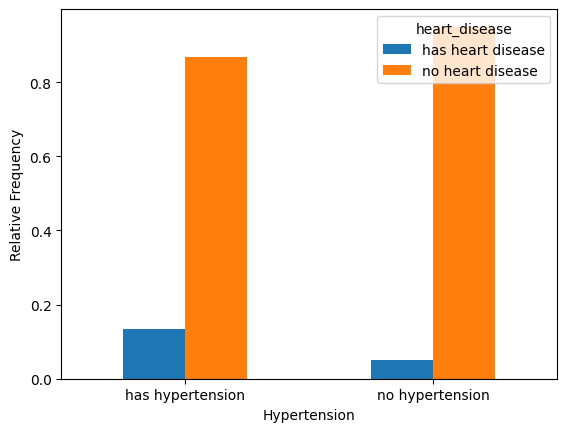

In [36]:
temp = pd.crosstab(df['hypertension'], df['heart_disease'], normalize='index')
temp.plot.bar()
plt.ylabel('Relative Frequency')
plt.xticks(rotation=0)
plt.xlabel('Hypertension')
plt.show()

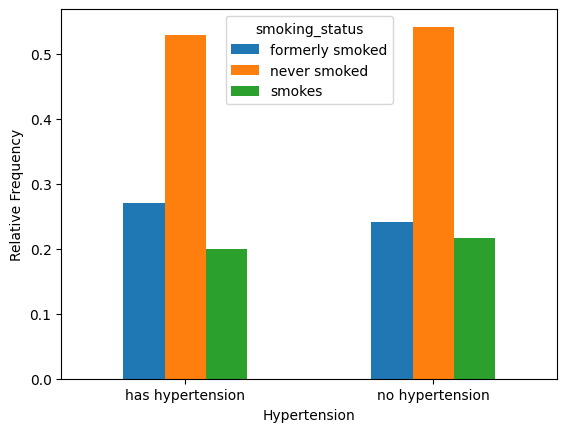

In [37]:
temp = pd.crosstab(df['hypertension'], df['smoking_status'], normalize='index')
temp.plot.bar()
plt.ylabel('Relative Frequency')
plt.xticks(rotation=0)
plt.xlabel('Hypertension')
plt.show()

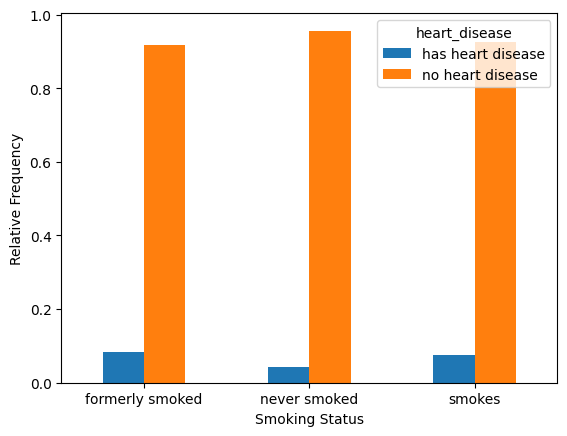

In [38]:
temp = pd.crosstab(df['smoking_status'], df['heart_disease'], normalize='index')
temp.plot.bar()
plt.ylabel('Relative Frequency')
plt.xticks(rotation=0)
plt.xlabel('Smoking Status')
plt.show()

### Interaction Effects

We now want to plot the interaction effects for each numeric explanatory variable with all the categorical explantory variables. First, we will make a 0/1 response variable 'y', by replacing 'stroke occurred' with a 1 and 'no stroke' with a 0.

### 0/1 Response Variable

In [39]:
df['y'] = df['stroke'].replace({'stroke occurred': 1, 'no stroke': 0})

#### Age with all categorical pairs

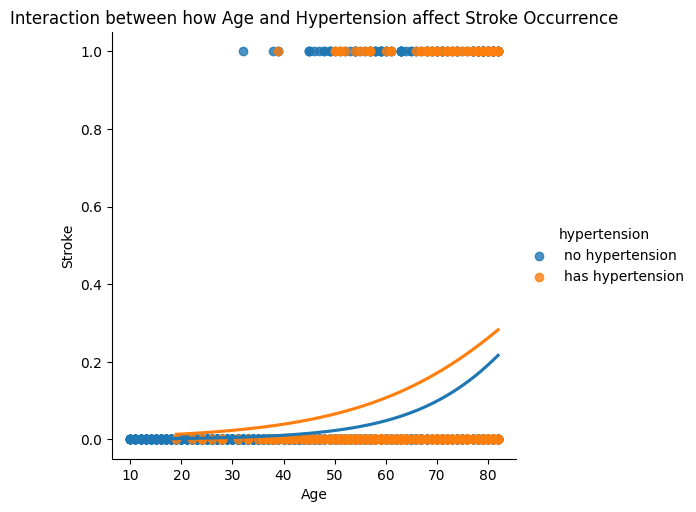

In [40]:
sns.lmplot(x='age', y='y', hue='hypertension', ci=False, logistic=True, data=df)
plt.xlabel('Age')
plt.ylabel('Stroke')
plt.title('Interaction between how Age and Hypertension affect Stroke Occurrence')
plt.show()

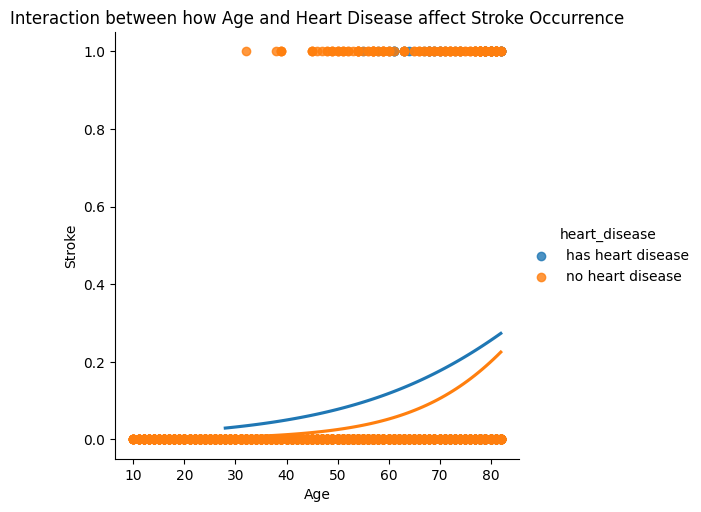

In [41]:
sns.lmplot(x='age', y='y', hue='heart_disease', ci=False, logistic=True, data=df)
plt.xlabel('Age')
plt.ylabel('Stroke')
plt.title('Interaction between how Age and Heart Disease affect Stroke Occurrence')
plt.show()

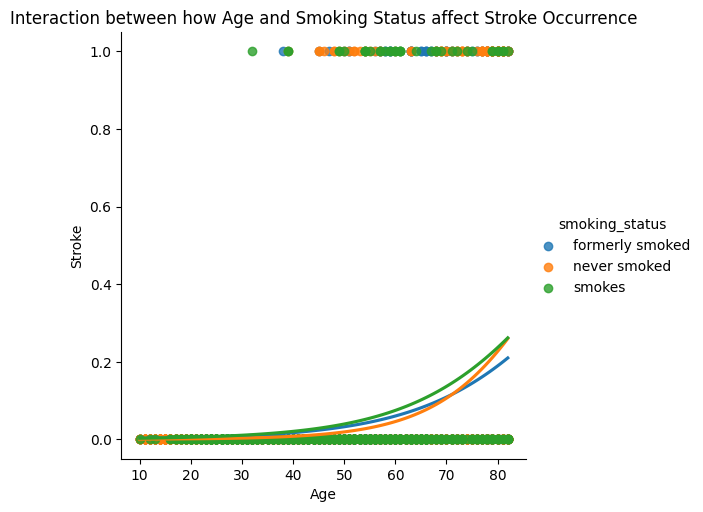

In [42]:
sns.lmplot(x='age', y='y', hue='smoking_status', ci=False, logistic=True, data=df)
plt.xlabel('Age')
plt.ylabel('Stroke')
plt.title('Interaction between how Age and Smoking Status affect Stroke Occurrence')
plt.show()

#### Average Glucose Levels with all categorical pairs

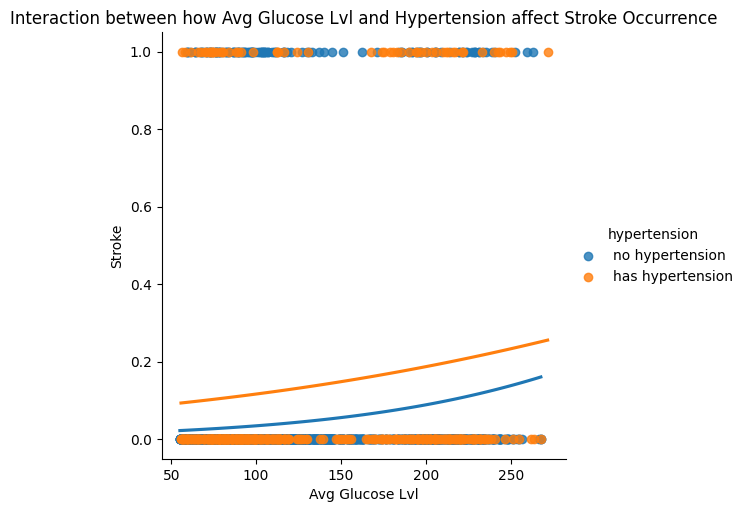

In [43]:
sns.lmplot(x='avg_glucose_level', y='y', hue='hypertension', ci=False, logistic=True, data=df)
plt.xlabel('Avg Glucose Lvl')
plt.ylabel('Stroke')
plt.title('Interaction between how Avg Glucose Lvl and Hypertension affect Stroke Occurrence')
plt.show()

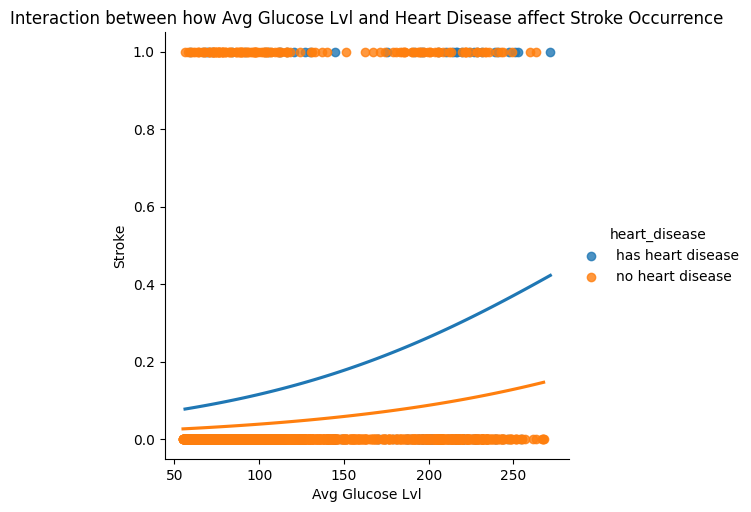

In [44]:
sns.lmplot(x='avg_glucose_level', y='y', hue='heart_disease', ci=False, logistic=True, data=df)
plt.xlabel('Avg Glucose Lvl')
plt.ylabel('Stroke')
plt.title('Interaction between how Avg Glucose Lvl and Heart Disease affect Stroke Occurrence')
plt.show()

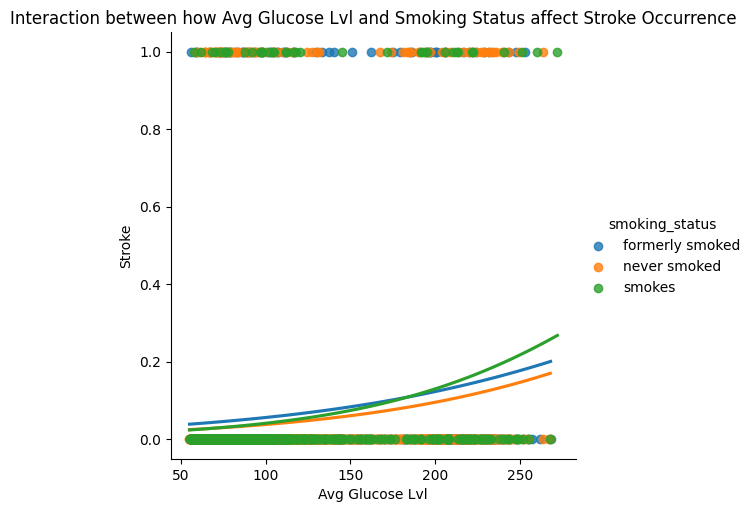

In [45]:
sns.lmplot(x='avg_glucose_level', y='y', hue='smoking_status', ci=False, logistic=True, data=df)
plt.xlabel('Avg Glucose Lvl')
plt.ylabel('Stroke')
plt.title('Interaction between how Avg Glucose Lvl and Smoking Status affect Stroke Occurrence')
plt.show()

#### BMI with all categorical pairs

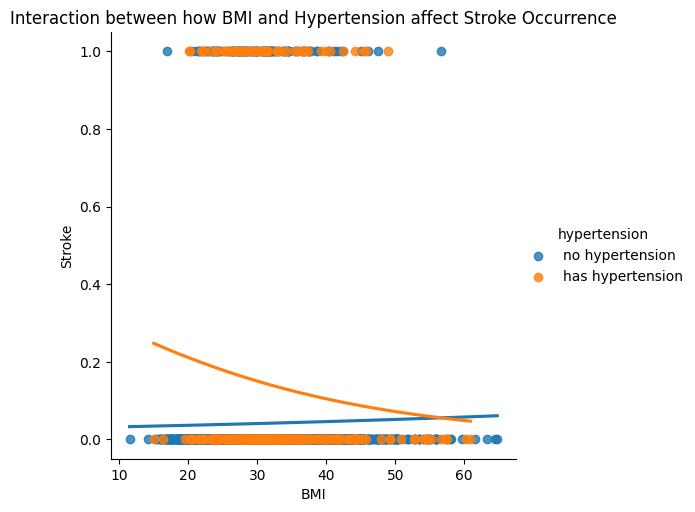

In [46]:
sns.lmplot(x='bmi', y='y', hue='hypertension', ci=False, logistic=True, data=df)
plt.xlabel('BMI')
plt.ylabel('Stroke')
plt.title('Interaction between how BMI and Hypertension affect Stroke Occurrence')
plt.show()

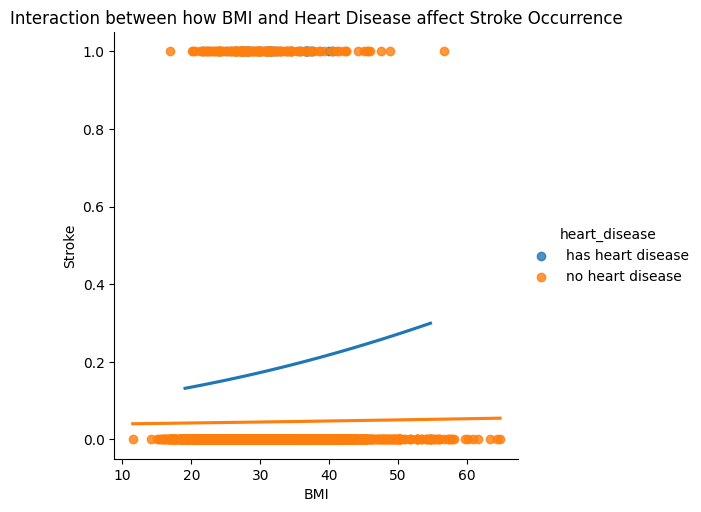

In [47]:
sns.lmplot(x='bmi', y='y', hue='heart_disease', ci=False, logistic=True, data=df)
plt.xlabel('BMI')
plt.ylabel('Stroke')
plt.title('Interaction between how BMI and Heart Disease affect Stroke Occurrence')
plt.show()

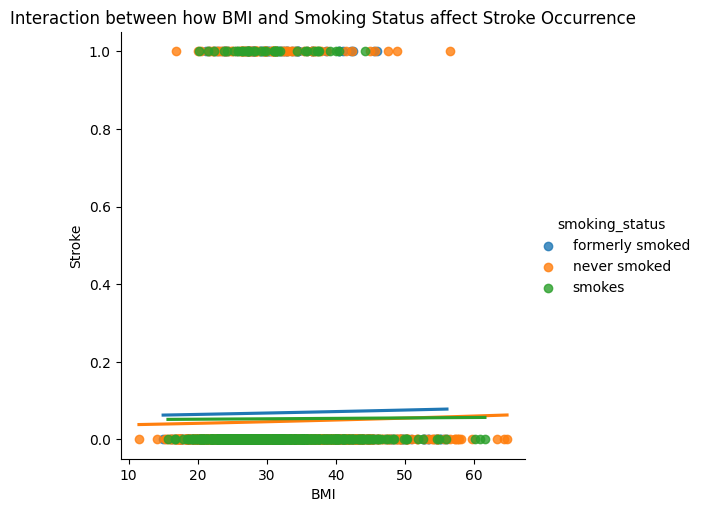

In [48]:
sns.lmplot(x='bmi', y='y', hue='smoking_status', ci=False, logistic=True, data=df)
plt.xlabel('BMI')
plt.ylabel('Stroke')
plt.title('Interaction between how BMI and Smoking Status affect Stroke Occurrence')
plt.show()

### Premilinary Analysis Discussion

Hypertension, heart disease, age, and average glucose level have a strong relationship with the stroke response variable. The relationship with hypertension and heart disease can be seen by the difference in the heights of the bar plots. The relationship between age and average glucose level with the response variable can be seen by the difference in the IQRs of the respective box plots. BMI and Smoking Status have weak relationships with the stroke response variable. Age has a strong association with both hypertension and heart disease. This can again be seen by the difference in the IQRs of the respective box plots. Average glucose level has a strong association with hypertension and heart disease. There are interactions with BMI and Heart Disease as well as BMI and Hypertension. 

## 5. Model Data Preprocessing

### Features Matrix and Target Array

We begin our preprocessing step by making the features matrix and target array.

In [49]:
X = df.drop('stroke', axis=1).drop('y', axis=1)
X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status
0,67.0,no hypertension,has heart disease,228.69,36.6,formerly smoked
2,80.0,no hypertension,has heart disease,105.92,32.5,never smoked
3,49.0,no hypertension,no heart disease,171.23,34.4,smokes
4,79.0,has hypertension,no heart disease,174.12,24.0,never smoked
5,81.0,no hypertension,no heart disease,186.21,29.0,formerly smoked


In [50]:
y = df['y']
y.head()

0    1
2    1
3    1
4    1
5    1
Name: y, dtype: int64

### Explantory Variable Scaling

Next, we scale our explanatory variables to be able to compare slopes of our model to see which variables bring the most predictive power. The standard deviation should all be the same to be able to make this comparison.

In [51]:
scaler = StandardScaler()
X_num = X[['age', 'avg_glucose_level', 'bmi']]
scaled_vars = scaler.fit_transform(X_num)
X_num = pd.DataFrame(scaled_vars, columns=X_num.columns)
X_num.std()

age                  1.000146
avg_glucose_level    1.000146
bmi                  1.000146
dtype: float64

### Indicator Variables

We also need to create indicator variables for Scikit-learn's model to operate.

In [52]:
X_cat = X[['smoking_status']]
X_cat = pd.get_dummies(X_cat, drop_first=True, dtype=int)
X_cat.head()

,smoking_status_never smoked,smoking_status_smokes
0,0,0
2,1,0
3,0,1
4,1,0
5,0,0


In [53]:
# Remapping original 0/1 categorical variables back into binary
X_cat2 = X[['hypertension', 'heart_disease']].copy()
X_cat2['hypertension'] = X_cat2['hypertension'].map({"no hypertension": 0, "has hypertension": 1})
X_cat2['heart_disease'] = X_cat2['heart_disease'].map({"no heart disease": 0, "has heart disease": 1})
X_cat2.head()

,hypertension,heart_disease
0,0,1
2,0,1
3,0,0
4,1,0
5,0,0


In [54]:
X_cat = pd.concat([X_cat2, X_cat], axis=1)
X_cat.head()

,hypertension,heart_disease,smoking_status_never smoked,smoking_status_smokes
0,0,1,0,0
2,0,1,1,0
3,0,0,0,1
4,1,0,1,0
5,0,0,0,0


In [55]:
X_num = X_num.reset_index(drop=True)
X_cat = X_cat.reset_index(drop=True)
X = pd.concat([X_num, X_cat], axis=1)
X.head()

,age,avg_glucose_level,bmi,hypertension,heart_disease,smoking_status_never smoked,smoking_status_smokes
0,0.973003,2.524950,0.889950,0,1,0,0
1,1.662642,-0.050306,0.315705,0,1,1,0
2,0.018117,1.319654,0.581819,0,0,0,1
3,1.609593,1.380275,-0.874803,1,0,1,0
4,1.715691,1.633878,-0.174504,0,0,0,0


## 6. Feature Selection with k-Fold Cross-Validation

Let's begin by making a KFold object for cross validation. This will use different sections of the data to try to get the most meaningful scores by using all parts of the data.

In [56]:
cross_val = KFold(n_splits=5, shuffle=True, random_state=207)
cross_val

KFold(n_splits=5, random_state=207, shuffle=True)

We chose the LASSO method because it allows us to clearly see the level of importance of each explanatory variable, since overfitted variables will have their slopes set to exactly 0. We will use many different values of lambda_ and find the best one by seeing which has the highest average ROC AUC score among all folds. 

In [57]:
temp_list=[]
for lambda_ in np.arange(0.01, 2, 0.01):
    lasso_model = LogisticRegression('l1', solver='liblinear', max_iter=1000, C=1/lambda_)
    roc_auc = cross_val_score(lasso_model, X, y, cv=cross_val, scoring="roc_auc")
    temp_list.append([lambda_, roc_auc.mean()])
    
lasso_df = pd.DataFrame(temp_list, columns=['lambda', 'avg roc auc'])
lasso_df['avg roc auc'].max()

0.8266270800799693

In [58]:
lasso_df.head()

,lambda,avg roc auc
0,0.01,0.826522
1,0.02,0.826538
2,0.03,0.826571
3,0.04,0.826548
4,0.05,0.826557


Let's plot all these average AUC scores for all the variables of lambda to clearly see the peak.

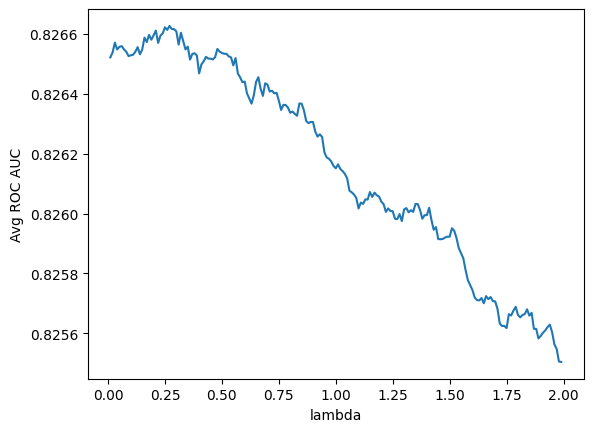

In [59]:
plt.plot(lasso_df['lambda'].values, lasso_df['avg roc auc'].values)
plt.xlabel('lambda')
plt.ylabel('Avg ROC AUC')
plt.show()

In [60]:
lasso_df[lasso_df['avg roc auc'] == lasso_df['avg roc auc'].max()]

,lambda,avg roc auc
26,0.27,0.826627


Our highest average ROC AUC score was 0.826638, with the corresponding lambda values of 0.27. I want to compare that against a non-regularized, full model, so let's check that now.

In [61]:
full_model = LogisticRegression(penalty='none', solver='newton-cg', max_iter=1000)
roc_auc = cross_val_score(full_model, X, y, cv=cross_val, scoring="roc_auc")
print(f'ROC AUC Mean: {roc_auc.mean()}')

ROC AUC Mean: 0.8265861744415268


This ROC AUC Mean is slightly lower, indicating the the small amount of regularization was beneficial.

## 7. Best Model Discussion

We will now use the best model that we found and use a train-test split to test it.

### Train-Test-Split

In [62]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
df = pd.concat([X, y], axis=1)
df.head()

,age,avg_glucose_level,bmi,hypertension,heart_disease,smoking_status_never smoked,smoking_status_smokes,y
0,0.973003,2.524950,0.889950,0,1,0,0,1
1,1.662642,-0.050306,0.315705,0,1,1,0,1
2,0.018117,1.319654,0.581819,0,0,0,1,1
3,1.609593,1.380275,-0.874803,1,0,1,0,1
4,1.715691,1.633878,-0.174504,0,0,0,0,1


In [63]:
train, test = train_test_split(df, test_size=0.2, random_state=207)

In [64]:
X_train = train.drop('y', axis=1)
X_test = test.drop('y', axis=1)
y_train = train['y']
y_test = test['y']

### Fit the Chosen Model

In [65]:
lasso_model = LogisticRegression('l1', solver='liblinear', max_iter=1000, C=1/0.27)
lasso_model.fit(X_train, y_train)

LogisticRegression(C=3.7037037037037033, max_iter=1000, penalty='l1',
                   solver='liblinear')

### Equation

In [66]:
intercept = lasso_model.intercept_
intercept

array([-3.9739541])

In [67]:
df_coef = pd.DataFrame(lasso_model.coef_.T, columns=['Lasso Model'], index=X_train.columns)
df_coef

,Lasso Model
age,1.405462
avg_glucose_level,0.234274
bmi,0.054929
hypertension,0.500671
heart_disease,0.353045
smoking_status_never smoked,-0.102730
smoking_status_smokes,0.488654


$ StrokeProb^{hat}$ = 1 / (1 + e^-(-3.974 <br>
    + 1.405 x $Age$ <br>
    + 0.234 x $AvgGlucoseLevel$ <br>
    + 0.055 x $BMI$ <br>
    + 0.500 x $Hypertension$ <br>
    + 0.353 x $HeartDisease$ <br>
    - 0.103 x $SmokingStatusNeverSmoked$ <br>
    + 0.489 x $SmokingStatusSmokes$ <br>))

### Multicollinearity

It is important we check for multicollinearity so that we can ensure our results remain interpretable.

In [68]:
X_train[['age', 'avg_glucose_level', 'bmi']].corr()

,age,avg_glucose_level,bmi
age,1.000000,0.242174,0.081633
avg_glucose_level,0.242174,1.000000,0.156347
bmi,0.081633,0.156347,1.000000


Should be no issues with multicollinearity.

### Test ROC and AUC

Now, we will plot the ROC curve.

In [69]:
# Predict probabilities for each class
predictive_prob = lasso_model.predict_proba(X_test)
prob_pos_class = predictive_prob[:, 1]
auc = roc_auc_score(y_true=y_test, y_score=prob_pos_class)
print(f'AUC: {auc}')

AUC: 0.7817582605718199


In [70]:
fprs, tprs, thresholds = roc_curve(y_true=y_test, y_score=prob_pos_class)

In [71]:
def plot_roc(fpr, tpr, auc, lw=2):
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = '+str(round(auc,3))+')')
    plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

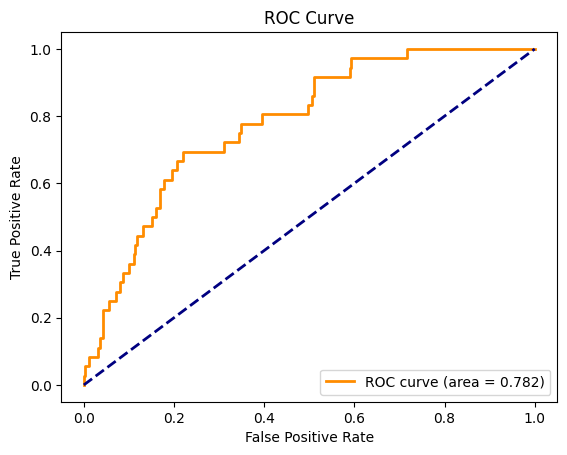

In [72]:
plot_roc(fprs, tprs, auc)

### Best Predictive Probability Threshold

For our research goal, we would like ideally like to minimize the number of people in the dataset who actually had a stroke to be misclassified. If there are people that did not have a stroke that are classified as having one, it is less important. This is because if someone is at risk of having a stroke, they should be appropriately notified rather than predicting them to be not at risk. This means we want the True Positive Rate to be as high as possible, with minimizing the False Positive Rate coming in as a secondary concern.

In [73]:
def fpr_tpr_thresh(y, pred_prob, thresh):
    y_hat = 1 * (pred_prob >= thresh)
    tn, fp, fn, tp = confusion_matrix(y_true=y, y_pred=y_hat).ravel()
    tpr = tp / (fn + tp)
    fpr = fp / (fp + tn)
    return pd.DataFrame({'threshold':[thresh], 'fpr':[fpr], 'tpr':[tpr]})

In [74]:
for thresh in np.arange(0, 0.08, 0.0005):
    print(fpr_tpr_thresh(y_test, prob_pos_class, thresh))

   threshold  fpr  tpr
0        0.0  1.0  1.0
   threshold  fpr  tpr
0     0.0005  1.0  1.0
   threshold       fpr  tpr
0      0.001  0.990755  1.0
   threshold       fpr  tpr
0     0.0015  0.959938  1.0
   threshold       fpr  tpr
0      0.002  0.930663  1.0
   threshold       fpr  tpr
0     0.0025  0.901387  1.0
   threshold       fpr  tpr
0      0.003  0.884438  1.0
   threshold       fpr  tpr
0     0.0035  0.858243  1.0
   threshold       fpr  tpr
0      0.004  0.839753  1.0
   threshold       fpr  tpr
0     0.0045  0.813559  1.0
   threshold      fpr  tpr
0      0.005  0.79661  1.0
   threshold       fpr  tpr
0     0.0055  0.773498  1.0
   threshold       fpr  tpr
0      0.006  0.761171  1.0
   threshold       fpr  tpr
0     0.0065  0.744222  1.0
   threshold       fpr  tpr
0      0.007  0.727273  1.0
   threshold       fpr       tpr
0     0.0075  0.714946  0.972222
   threshold       fpr       tpr
0      0.008  0.707242  0.972222
   threshold       fpr       tpr
0     0.0085  0.6

If we want the TPR to be at least 90%, the best threshold is at 0.02. At this threshold, the FPR is minimized while still having over 90% TPR.

### Discussion
We can conclude that a lambda with a value of 0.27 is the best using the Lasso regularization method. There is no multicollinearity in our model because all of the numerical variables we are using have a coefficient that is less than 0.7. We can also interpret the slopes of our model for predictive power because we scaled all of our variables and there is no multicollinearity present in this model. With that being said, we can tell that age, hypertension, and smoking status are the variables with the highest predictive power. 
	According to our best Lasso model, none of our explanatory variables were overfitting. We know this because in our best model, none of the slopes are zeroed out. While BMI is close to being zeroed out, our model still shows it has some benefit to being kept for predicting strokes. All of the explanatory variables are shown not to have a strong association with each other. Also, our best model had a test AUC of 0.782. This means our model is good, but not great for predicting TPR of a person having a stroke. Like we mentioned earlier, it is more important to have a better TPR than a FPR due to the seriousness of a person having a stroke.


## 8. Additional Analysis/Insight

The additional analysis we will be doing is to use K-Means clustering for the explanatory variables age and average glucose levels. This will help advance our third research goal where we want to examine relationships and find possible dynamics between explanatory variables. We used a YouTube video and the Scikit-learn documentation to do this, which is credited at the end of the report.

In [75]:
X.head()

,age,avg_glucose_level,bmi,hypertension,heart_disease,smoking_status_never smoked,smoking_status_smokes
0,0.973003,2.524950,0.889950,0,1,0,0
1,1.662642,-0.050306,0.315705,0,1,1,0
2,0.018117,1.319654,0.581819,0,0,0,1
3,1.609593,1.380275,-0.874803,1,0,1,0
4,1.715691,1.633878,-0.174504,0,0,0,0


We will select just age and average glucose level, and use the "Elbow Method" to find the optimal number of clusters to use. We do this by plotting the sum of squared distances from each point to its assigned cluster center against the number of clusters. As the number of clusters k increases, the sum of squares within each cluster decreases. The plot typically shows a steep decline that levels off, forming an "elbow". The optimal number of clusters k is typically chosen at this elbow point, where adding another cluster doesn't give much better modeling of the data. This method helps balance the trade-off between the number of clusters and the compactness of the clusters.

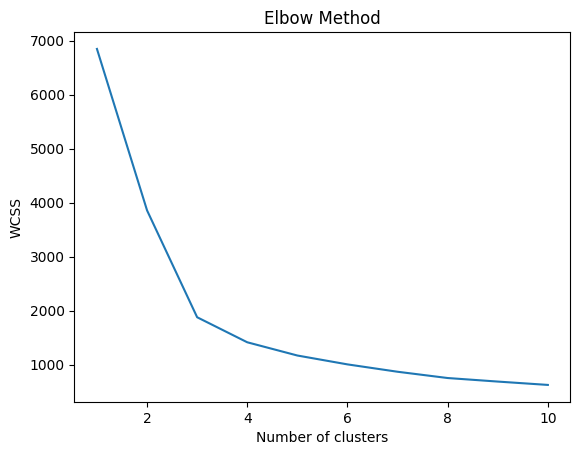

In [76]:
X = X[['age', 'avg_glucose_level']]
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

We can see that the "elbow" is at 3 clusters. Now let's plot the clusters and create the KMeans object.

In [77]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X)

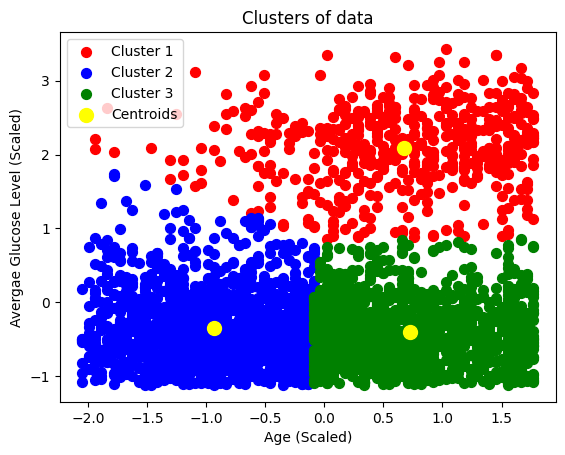

In [78]:
X = X.to_numpy()
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s=50, c='red', label ='Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s=50, c='blue', label ='Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s=50, c='green', label ='Cluster 3')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='yellow', label = 'Centroids')
plt.title('Clusters of data')
plt.xlabel('Age (Scaled)')
plt.ylabel('Avergae Glucose Level (Scaled)')
plt.legend()
plt.show()

Here we can see the three clusters, and although we are using scaled versions of our data, it helps our third research goal of examine the relationships between variables, namely age and average glucose level. As age increases, we see two distinct clusters, one with lower average glucose level and one with a higher average glucose level. This analysis might be helpful for doctors who are trying to determine groups of patients to medicate differently depending on their cluster to prevent a stroke from occurring.

## 9. Conclusion

We would recommend this model to be used by the person mentioned in our motivation. The test AUC is 0.782. This is a fairly high score which would indicate good performance for classifying the observations into classes. We do not know for sure that our chosen best model will yield the highest possible average test AUC out of all possible models that we could make with this dataset. This is because we only tried LASSO L1 penalty regularization, and there are other options out there. We could have also used a smaller step size to measure even more lambda values at the cost of time and efficiency. Also, different explanatory variables could have been selected at the beginning. Additional steps that a more complete analysis could have taken would be to try all of the different kinds of regression models. We used the LASSO regression model, but we could have also tried ridge regression or elastic net. Another step that could have been tried would be to experiment with the outliers. We could have left some outliers in or taken more out in the data cleaning process. A shortcoming of our model would be that we never get a true positive rate of close to 100% so our model should probably not be used to make serious medical decisions, but can still be used by doctors to get a general sense for trends that lead to strokes.